TASK 1

In [236]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas

Firstly, the dataset is loaded and the features (X) and target (y) are estracted as arrays. Next, the data is split into 80% training and 20% testing to evaluatethe model performance. Features are then scaled to have mean 0 and a standard deviation equal to 1, which helps models to converge faster and perform better.

In [ ]:
# load dataset
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data.values
y = diabetes.target.values
X.shape

# train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


(442, 10)

In this second part of the code, the cluster number was set to 4. This number was chosen by testing several options and observing how the MSE changed. 
The training features and target are concatenated to include the target in clustering. After this, fuzzy C-means clustering is performed. 

In [ ]:
 # Number of clusters 
n_clusters = 4
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

centers.shape

This section computes the spread of each cluster, which quantifies how dispersed the data points are around the cluster centers.

In [242]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Here, the fuzzy memberships are converted into hard cluster assignments by selecting for each sample the cluster with the highest membership degree.
The FPC is printed to evaluate the clustering quality. The obtained value of 0.78 indicates a good clustering, since values closer to 1 indicate more distinct clusters. 
Additionally, a scatter plot of the first two features is generated where each point’s transparency reflects its membership degree to the cluster, giving a visual representation of how strongly each sample belongs to its assigned cluster. 

Fuzzy partition coefficient (FPC): 0.7803568220813839


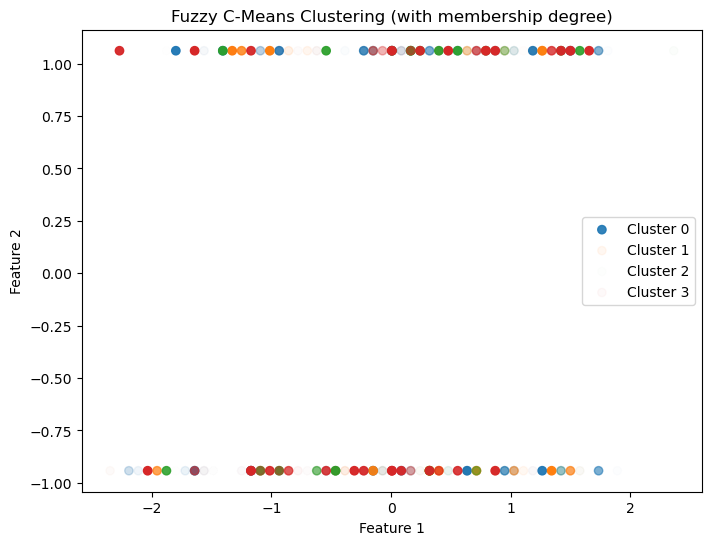

In [243]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

This plot shows the hard cluster assignments obtained from the Fuzzy C-Means algorithm, ignoring the membership degrees.

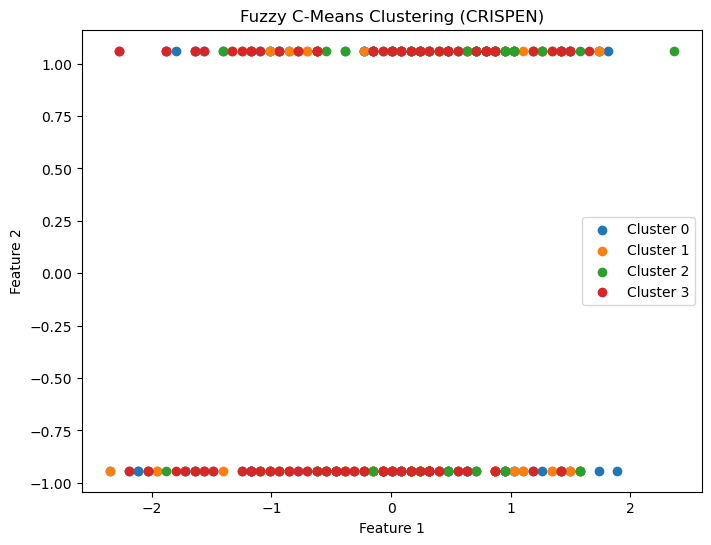

In [244]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The following plot shows the Gaussian membership functions for the first feature of each cluster. Each curve represents how strongly a value belongs to a cluster, based on the cluster’s center and spread. Peaks indicate the cluster centers and the width shows how spread out the cluster is.

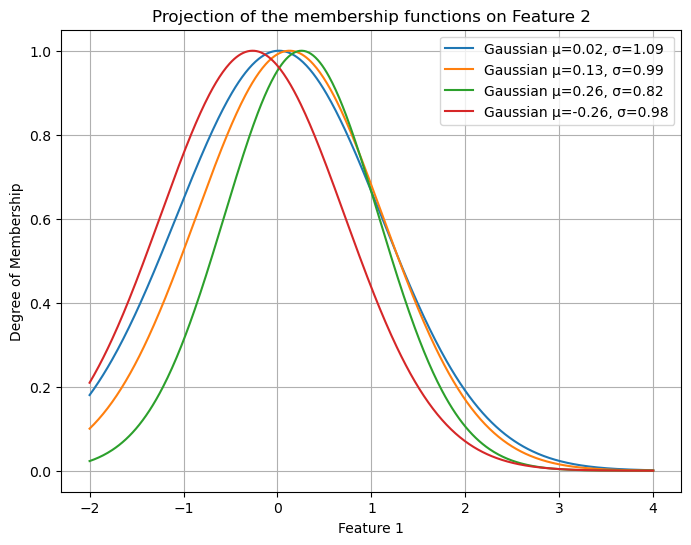

In [245]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

This section defines a TSK fuzzy model using PyTorch. Each input is evaluated for how strongly it belongs to each fuzzy rule and the rule outputs are combined using a weighted sum to obtain the final prediction.

In [246]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs


This section trains the TSK model's consequents using least squares. 

In [247]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

Then, the TSK model is created using the number of inputs and clusters determined earlier, along with the computed clusters and spreads. The training and test data are converted to PyTorch tensors so that they can be used with the model for training and evaluation.

In [248]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


The model’s consequents are trained using the least squares method on the training data, updating the linear coefficients of each fuzzy rule to best fit the target values.

In [249]:
# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1))

Lastly, the trained model is used to predict the target values for the test set. 
The TSK model predicted the test data with a MSE of 2528.86, indicating how closely the model’s outputs match the actual target values. Lower MSE values would represent better prediction accuracy.

In [250]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2528.860595703125
